This file helps 
1. converts the ffmepge records to csv
2. do regression based on existing data

In [4]:
import csv

# converts ff_records.txt into csv
# fp = open("ff_records.txt", "r")
# fp_csv = open("ff_records.csv", "a")
fp = open("./raw_data/ff_records_1.txt", "r")
fp_csv = open("./raw_data/ff_records_1.csv", "a")
csv_write = csv.writer(fp_csv)
csv_write.writerow(["BER", "IBER", "NIBER", "PSNR", "SSIM"])
# csv_write.writerow(["BER", "IBER", "NIBER", "IBN", "NIBN", "PSNR", "SSIM"])
index = 0
row = []
for line in fp.readlines():
    index += 1
    if(index % 11 == 1): # bit error rate
        ber = float(line.split(" ")[-1])
        row.append(ber)
    elif(index % 11 == 2):
        Iber = float(line.split(" ")[-1])
        row.append(Iber)
    elif(index % 11 == 3):
        NIber = float(line.split(" ")[-1])
        row.append(NIber)
    elif(index % 11 == 9):
        psnr = float(line.split(" ")[-1])
        row.append(psnr)
    elif(index % 11 == 10):
        ssim = float(line.split(" ")[-1])        
        row.append(ssim)
        csv_write.writerow(row)
    elif (index % 11 == 0):
        row = []
# for line in fp.readlines():
#     index += 1
#     if(index % 12 == 1): # bit error rate
#         ber = float(line.split(" ")[-1])
#         row.append(ber)
#     elif(index % 12 == 3):
#         Iber = float(line.split(" ")[-1])
#         row.append(Iber)
#     elif(index % 12 == 4):
#         NIber = float(line.split(" ")[-1])
#         row.append(NIber)
#     elif(index % 12 == 8):
#         Ibn = int(line.split(" ")[-1])
#         row.append(Ibn)
#     elif(index % 12 == 9):
#         Nibn = int(line.split(" ")[-1])
#         row.append(Nibn)
#     elif(index % 12 == 10):
#         psnr = float(line.split(" ")[-1])
#         row.append(psnr)
#     elif(index % 12 == 11):
#         ssim = float(line.split(" ")[-1])        
#         row.append(ssim)
#         csv_write.writerow(row)
#     elif (index % 12 == 0):
#         row = []
fp.close()
fp_csv.close()
print("Executed!")

Executed!


In [6]:
# combine and average the data row with the same IBER and NIBER
fp_csv = open("ff_records.csv", "r")
fp_ext = open("ff_records_final.csv", "a")
csv_read = csv.reader(fp_csv)
csv_write = csv.writer(fp_ext)
csv_write.writerow(["IBER", "NIBER","IBN","NIBN", "PSNR", "SSIM"])
firstline = 1
size = 0
group = 100
dic = {}
for row in csv_read:
    if firstline:
        firstline = 0
        continue
    size += 1
    if(size % group == 1 and size != 1):
        for it_key, it_value in dic.items():
            features = it_key.split("|")
            iber = float(features[0])
            niber = float(features[1])
            ibn = float(features[2])
            nibn = float(features[3])
            length = len(it_value)
            count = 0
            psnr_avg = 0
            ssim_avg = 0
            while count < length:
                if count % 2 == 0:
                    psnr_avg += float(it_value[count])
                else:
                    ssim_avg += float(it_value[count])
                count += 1
            psnr_avg /= (length/2)
            ssim_avg /= (length/2)
            psnr_avg = round(psnr_avg, 6)
            ssim_avg = round(ssim_avg, 6)
            # if(iber != 0 and niber !=0):
            csv_write.writerow([iber, niber,ibn, nibn, psnr_avg, ssim_avg])
        dic.clear()
    key = str(row[1]) + str("|") + str(row[2]) + str("|") + str(row[3]) + str("|") + str(row[4])
    value = []
    value.append(row[5])
    value.append(row[6])
    if key in dic:
        dic[key] = dic[key] + value
        # print(dic[key])
    else:
        dic[key] = value
for it_key, it_value in dic.items():
    features = it_key.split("|")
    iber = float(features[0])
    niber = float(features[1])
    ibn = float(features[2])
    nibn = float(features[3])
    length = len(it_value)
    count = 0
    psnr_avg = 0
    ssim_avg = 0
    while count < length:
        if count % 2 == 0:
            psnr_avg += float(it_value[count])
        else:
            ssim_avg += float(it_value[count])
        count += 1
    psnr_avg /= (length/2)
    ssim_avg /= (length/2)
    psnr_avg = round(psnr_avg, 6)
    ssim_avg = round(ssim_avg, 6)
    # if(iber != 0 and niber !=0):
    csv_write.writerow([iber, niber, ibn, nibn, psnr_avg, ssim_avg])
# print(dic)
fp_csv.close()
fp_ext.close()
print("Executed!")

Executed!


-3.251159176508417 -0.6695670152333499


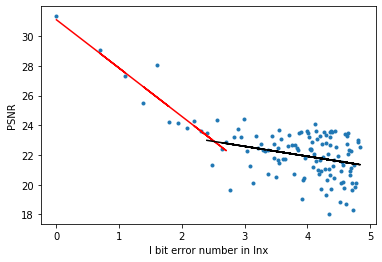

-3.2567825724947204


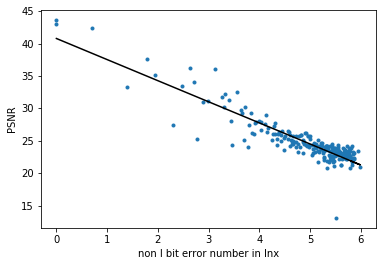

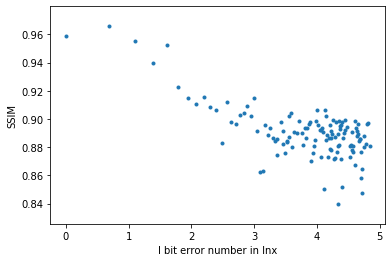

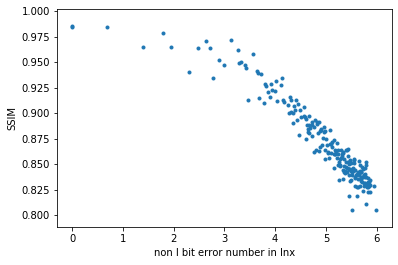

In [49]:
# data preparations for second round exp
# TODO: uni-variant regression and visualization
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import math

stat = pd.read_csv("ff_records_final.csv")
stat.columns = ['ibr','nibr','ibn','nibn','psnr','ssim']
stat_arr = np.array(stat)
#for i and non i seperately
stat_i = stat_arr[np.where(stat_arr[:,1] == 0)]
stat_ni = stat_arr[np.where(stat_arr[:,0] == 0)]

ibn_trim = stat_i[1:,2]
nibn_trim = stat_ni[1:,3]
psnr_ibn_trim = (stat_i[1:,4])
psnr_nibn_trim = stat_ni[1:,4]
ssim_ibn_trim = stat_i[1:,5]
ssim_nibn_trim = stat_ni[1:,5]

ibn_log = np.array([math.log(x) for x in ibn_trim])
nibn_log = np.array([math.log(x) for x in nibn_trim])



label_title = "test"
plt.scatter(ibn_log, psnr_ibn_trim, label = label_title, marker=".")
plt.xlabel("I bit error number in lnx")
plt.ylabel("PSNR")
m, b = np.polyfit(ibn_log[0:13], psnr_ibn_trim[0:13], 1)
m2, b2 = np.polyfit(ibn_log[13:], psnr_ibn_trim[13:], 1)
plt.plot(ibn_log[0:13], m*ibn_log[0:13] + b, color='red')
plt.plot(ibn_log[13:], m2*ibn_log[13:] + b2, color='black')
print(m, m2)
plt.show()
# plt.savefig("./charts/IberPSNR.png",format="png")

# print(BR[0])
plt.scatter(nibn_log, psnr_nibn_trim, label = label_title, marker=".")
plt.xlabel("non I bit error number in lnx")
plt.ylabel("PSNR")
m, b = np.polyfit(nibn_log, psnr_nibn_trim, 1)
plt.plot(nibn_log, m*nibn_log + b, color='black')
print(m)
plt.show()
# plt.savefig("./charts/IberPSNR.png",format="png")

plt.scatter(ibn_log, ssim_ibn_trim, marker='.')
plt.xlabel("I bit error number in lnx")
plt.ylabel("SSIM")
plt.show()
# plt.savefig("./charts/iberSSIM.png",format="png")

plt.scatter(nibn_log, ssim_nibn_trim, marker='.')
plt.xlabel("non I bit error number in lnx")
plt.ylabel("SSIM")
plt.show()




513


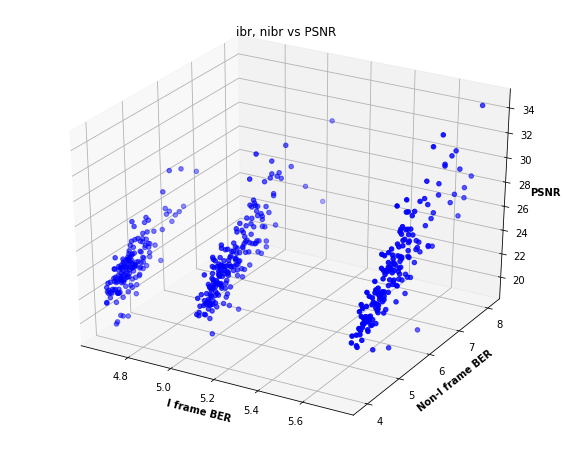

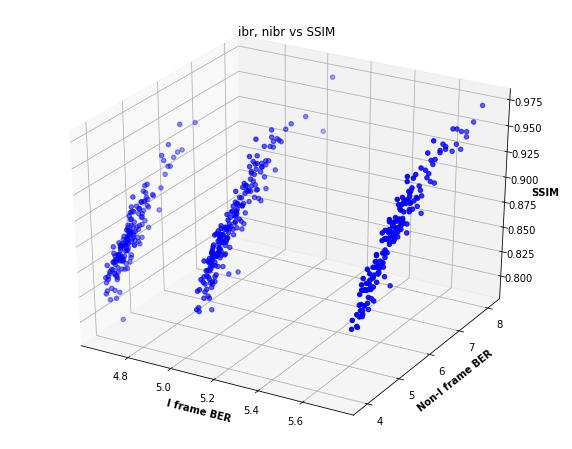

In [66]:
# data prepartions for first round of experiment
# multi variable processing
stat = pd.read_csv("./raw_data/ff_records_final_1.csv")
stat.columns = ['ibr','nibr','psnr','ssim']
stat_arr = np.array(stat)

stat_trim = stat_arr[np.where(stat_arr[..., 0] < 0.01)]

ibr = stat_trim[...,0]
nibr = stat_trim[...,1]
psnr = stat_trim[...,2]
ssim = stat_trim[...,3]
BR = stat_trim[...,0:2]

print(len(stat_trim))


ibr_log = [-math.log(x) for x in ibr]
nibr_log = [-math.log(x) for x in nibr]
BR_log = [[-math.log(x[0]), -math.log(x[1])] for x in BR]
# print(ibr)
# print(ibn)


# label_title = "test"
# plt.scatter(ibn_log, psnr_ibn_trim, label = label_title, marker=".")
# plt.xlabel("non I frame bit error rate lnx")
# plt.ylabel("PSNR")
# plt.show()
# # plt.savefig("./charts/IberPSNR.png",format="png")
# plt.scatter(ibn_log, ssim_ibn_trim, marker='.')
# plt.xlabel("non I frame bit error rate lnx")
# plt.ylabel("SSIM")
# plt.show()
# # plt.savefig("./charts/iberSSIM.png",format="png")
# # print(BR[0])
# plt.scatter(nibn_log, psnr_nibn_trim, label = label_title, marker=".")
# plt.xlabel("non I frame bit error rate lnx")
# plt.ylabel("PSNR")
# plt.show()
# # plt.savefig("./charts/IberPSNR.png",format="png")
# plt.scatter(nibn_log, ssim_nibn_trim, marker='.')
# plt.xlabel("non I frame bit error rate lnx")
# plt.ylabel("SSIM")
# plt.show()

# creating figure
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
# creating plot
ax.scatter3D(ibr_log, nibr_log, psnr, color = "blue")
plt.title("ibr, nibr vs PSNR")
ax.set_xlabel("I frame BER", fontweight="bold")
ax.set_ylabel("Non-I frame BER", fontweight="bold")
ax.set_zlabel("PSNR", fontweight="bold")
# plt.savefig("./charts/berPSNR3d.png", format="png")
plt.show()

# creating figure
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.scatter3D(ibr_log, nibr_log, ssim, color = "blue")
plt.title("ibr, nibr vs SSIM")
ax.set_xlabel("I frame BER", fontweight="bold")
ax.set_ylabel("Non-I frame BER", fontweight="bold")
ax.set_zlabel("SSIM", fontweight="bold")
# plt.savefig("./charts/berSSIM3d.png", format="png")
plt.show()

In [67]:
# multi-variant Linear regression
# TODO a 3-d visualization
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(BR_log, psnr)
r2_score = model.score(BR_log, psnr)
print("PSNR--------------------")
print("R2 score is:", r2_score)
print('coefficient of determination:', model.coef_)
print("interception is:", model.intercept_)
print("SSIM--------------------")
model.fit(BR_log, ssim)
r2_score = model.score(BR_log, ssim)
print("R2 score is:", r2_score)
print('coefficient of determination:', model.coef_)
print("interception is:", model.intercept_)


PSNR--------------------
R2 score is: 0.5956381204494222
coefficient of determination: [1.04877948 2.16278918]
interception is: 8.464510123903896
SSIM--------------------
R2 score is: 0.8146333666436785
coefficient of determination: [0.0116427  0.03660255]
interception is: 0.6445053645396605
